In [106]:
import argparse
import random

import numpy as np
import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from ignite.engine import Engine, Events
from ignite.handlers import ModelCheckpoint
from torch.utils.data import DataLoader, IterableDataset, get_worker_info

CHECKPOINT_PREFIX = "g2g"

from g2g_model_Fisher_radius import CompleteKPartiteGraph,AttributedGraph,GraphDataset,Encoder,\
                            level_sets,train_test_split,reset_seeds


In [107]:
torch.cuda.is_available()
# torch.cuda.device_count()
# torch.cuda.current_device()

False

In [108]:
print(torch.__version__)
print(torch.version.cuda)

2.0.1+cpu
None


In [109]:
import scvelo as scv
import numpy as np
from anndata import AnnData
# import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import fcluster,leaders
from sklearn.decomposition import PCA
from scipy.linalg import inv
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from RKHS import SparseVFC
from RKHS import Jacobian_rkhs_gaussian
from scipy.stats import multivariate_normal
from scipy.sparse import csr_matrix

In [110]:
data_path='data/'
result_path='result/'
adata0=scv.read(data_path+'EG_bin.h5ad', cache=True)

In [111]:
adata0

AnnData object with n_obs × n_vars = 1731 × 470
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
    var: 'highly_variable_genes', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca', 'umap', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_pca'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced', 'variance_velocity', 'velocity'
    obsp: 'connectivities', 'distances'

### 在PCA空间中投影adata0
有scv自行计算

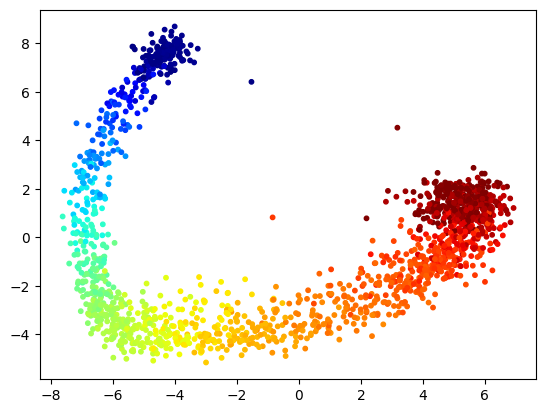

In [112]:
plt.scatter(adata0.obsm['X_pca'][:,0],adata0.obsm['X_pca'][:,1],s=10,c=adata0.obs['velocity_pseudotime'].values,cmap=plt.cm.jet)
plt.show()

# plt.scatter(adata0.obsm['X_pca'][:,0],adata0.obsm['X_pca'][:,1],s=10,c=adata0.layers['variance_velocity'],cmap=plt.cm.jet)
# plt.show()

In [113]:
#-------data preprocessing
k_nei=adata0.shape[0] # 10-NN
adata=adata0.copy()
scv.pp.neighbors(adata, n_neighbors=k_nei) # 计算了每个点的KNN
scv.pp.pca(adata,n_comps=50)
scv.pp.moments(adata, n_pcs=50, n_neighbors=k_nei)

computing neighbors
    finished (0:00:07) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [114]:
print(adata.obsp['distances']) # connectivities是带权的,打印distances检验：distance越大，权越小

  (0, 1)	9.149542808532715
  (0, 2)	10.71268367767334
  (0, 3)	9.273341178894043
  (0, 4)	10.18474006652832
  (0, 5)	13.867879867553711
  (0, 6)	13.729862213134766
  (0, 7)	8.731307983398438
  (0, 8)	8.825098037719727
  (0, 9)	7.630875110626221
  (0, 10)	7.68046760559082
  (0, 11)	14.089366912841797
  (0, 12)	9.643181800842285
  (0, 13)	8.30846881866455
  (0, 14)	9.839481353759766
  (0, 15)	8.784097671508789
  (0, 16)	9.966002464294434
  (0, 17)	9.456517219543457
  (0, 18)	13.380431175231934
  (0, 19)	12.464344024658203
  (0, 20)	11.13395881652832
  (0, 21)	9.909287452697754
  (0, 22)	8.272302627563477
  (0, 23)	9.14157772064209
  (0, 24)	9.167875289916992
  (0, 25)	7.336887836456299
  :	:
  (1730, 1705)	9.45569896697998
  (1730, 1706)	11.285122871398926
  (1730, 1707)	9.07728099822998
  (1730, 1708)	13.074216842651367
  (1730, 1709)	7.630465030670166
  (1730, 1710)	13.317743301391602
  (1730, 1711)	10.537426948547363
  (1730, 1712)	5.2080888748168945
  (1730, 1713)	9.23450756072998
  

In [115]:
adata.uns['neighbors']
# neighbors记录了每个点的k_nei个最近邻编号，每个点的最近邻包括自身

{'connectivities_key': 'connectivities',
 'distances_key': 'distances',
 'indices': array([[   0,  541,   83, ..., 1073,  270,  627],
        [   1,  435,  831, ...,  539, 1235, 1521],
        [   2,   99,  443, ...,  485,  270,  149],
        ...,
        [1728, 1709, 1463, ...,  627, 1499, 1123],
        [1729, 1643,  402, ...,  131,  270, 1123],
        [1730,  709, 1145, ...,  799,   51, 1235]], dtype=int64),
 'params': {'n_neighbors': 1731,
  'method': 'umap',
  'metric': 'euclidean',
  'n_pcs': None,
  'use_rep': 'X_pca'}}

In [116]:
row = np.array([np.ones((k_nei,))*i for i in range(adata.shape[0])]).flatten()
# row=[0,……0，1，……1，2，……adata.shape[0]]，k个0，k个1，……，k个adata.shape[0]

col=adata.uns['neighbors']['indices'].flatten()

adj_val=np.ones(col.shape)

A_mat=csr_matrix((adj_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))
# A_mat 就是把adata.obsp['connectivities']换成了0-1表示邻接关系的无权图，遗忘了边权

In [117]:
adata0.layers['Ms'].shape
# 3184个细胞，678个基因，Ms是spliced RNA

(1731, 470)

In [118]:
X0_ori=adata0.layers['Ms'] #adata.X.A#
scaler=MinMaxScaler(feature_range=(0,1))#StandardScaler()#
# 就是把数据归一化到（0，1）之间，x-min/max-min
X=scaler.fit_transform(X0_ori)
# 现在，X是归一化的spliced RNA数据

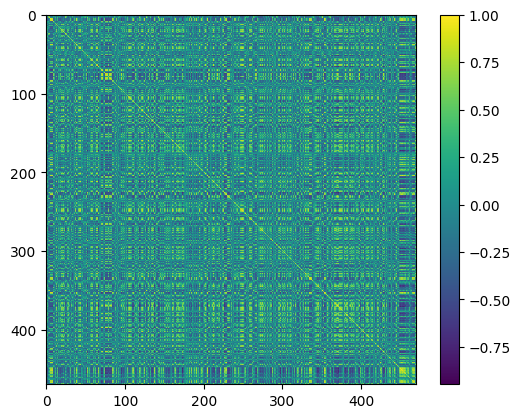

In [119]:
# X_corr是各基因之间的相关系数矩阵
X_corr=np.corrcoef(X, rowvar=False)
plt.imshow(X_corr)
plt.colorbar()
plt.show()

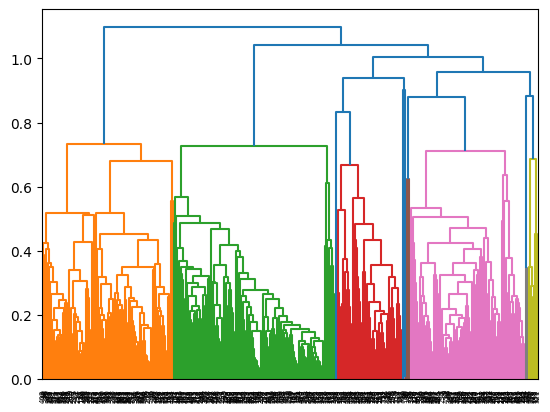

In [120]:
Z=linkage((1-X_corr)[np.triu_indices(X_corr.shape[0],k=1)],method='weighted')
dg=dendrogram(Z)
X_re= X[:,dg['leaves']]#X_re reorder X by clustering
# X_re是X 基因分量 按照 linkage聚类标签 重新排列后的数据

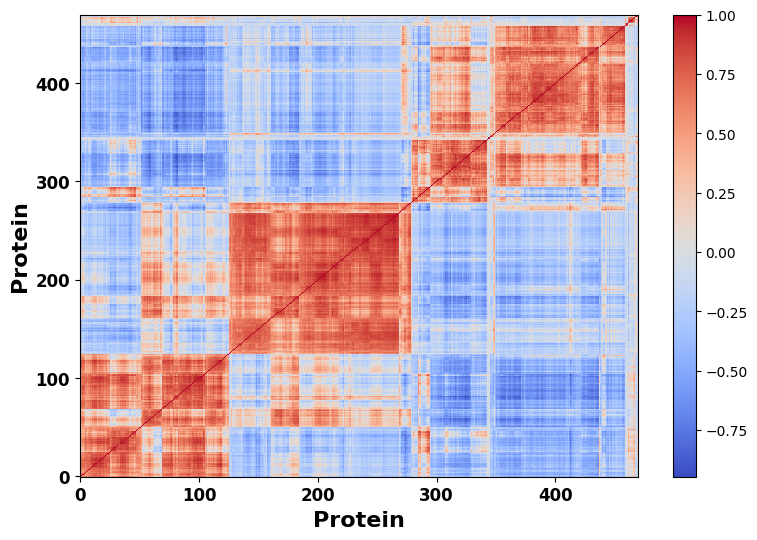

In [121]:
# X_corr_re是新的相关系数矩阵，用来展示eigen-gene合理性
X_corr_re=np.corrcoef(X_re, rowvar=False)

plt.figure(figsize=(9,6))
plt.imshow(X_corr_re, aspect='auto', cmap=plt.cm.coolwarm, interpolation='nearest',origin='lower')

plt.xlabel('Protein',fontsize=16,fontweight='bold')
plt.ylabel('Protein',fontsize=16,fontweight='bold')

plt.xticks(fontsize=12,fontweight='bold')
plt.yticks(fontsize=12,fontweight='bold')
plt.colorbar()
# plt.savefig('heatmap_order.png',dpi=300)
plt.show()

In [122]:
# Encoder training set

epochs = 200
nsamples = 5
learning_rate = 1e-3
seed = 0
n_workers = 0
K = 5# !!!!!!!!!! K should be large enough 这个K是GE计算中计算的邻居阶的最大值，只计算到K阶邻居
#     checkpoint_path = args.checkpoint
#     checkpoints_path = args.checkpoints
#     dataset_path = args.dataset

if seed is not None:
    reset_seeds(seed)

# A=A_mat # 无权邻接矩阵--KNN mode 

A = adata.obsp['distances'].toarray() # 球壳矩阵--radius layers mode 需要调整AttributedGraph中mode="r-mean"10-NN均值设定radius
# mode="r-max"10-NN最远距离设定radius  // mode="common"是所有点共用一个radius的模式

# D = adata.obsp['distances'].toarray() # 距离矩阵--radius mode 需要调整AttributedGraph中mode="KNN" 或设为默认值
# radius = np.zeros(adata.shape[0])
# for i in range(adata.shape[0]):
#     idx = np.argsort(D[i])[1:31]
#     radius[i] = np.mean(D[i,idx])

# A = csr_matrix(([], ([], [])), shape=(adata.shape[0], adata.shape[0]))

# for i in range(adata.shape[0]):
#     for j in range(adata.shape[0]):
#         if j == i:
#             A[i,i] = 1
#         else:
#             d = D[i,j]
#             if d <= radius[i]:
#                 A[i,j] = 1


# -------------------------------------------------------------------------------------------------------------------

X=X0_ori # 没有按照聚类重排列，即非Eigen gene坐标
#--------do not normalize X
# scaler=StandardScaler()#
# X=scaler.fit_transform(X0_ori)
z=adata0.obs['velocity_pseudotime'].values # z是伪时间坐标，用来染色

n = A.shape[0] # 细胞数目
train_nodes, val_nodes = train_test_split(n, train_ratio=1.0)
A_train = A[train_nodes, :][:, train_nodes]
X_train = X[train_nodes]
z_train = z[train_nodes]
A_val = A[val_nodes, :][:, val_nodes]
X_val = X[val_nodes]
z_val = z[val_nodes]

train_data = AttributedGraph(A_train, X_train, z_train, K, mode="common")
val_data = AttributedGraph(A_val, X_val, z_val, K, mode="common")

L = 3 # 嵌成三位Gaussian
encoder = Encoder(X.shape[1], L)

9.372001647949219


In [123]:
print(A)

[[ 0.          9.14954281 10.71268368 ...  8.08445549  6.93618107
   9.65952969]
 [ 9.14954281  0.         12.00878906 ...  9.02467823  9.02231503
   9.9786911 ]
 [10.71268368 12.00878906  0.         ... 11.25304604  8.50547791
  11.81762218]
 ...
 [ 8.08445549  9.02467823 11.25304604 ...  0.          7.33107662
   7.77598   ]
 [ 6.93618107  9.02231503  8.50547791 ...  7.33107662  0.
   9.81807423]
 [ 9.65952969  9.9786911  11.81762218 ...  7.77598     9.81807423
   0.        ]]


In [124]:
optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)

iterations = epochs
dataset = GraphDataset(train_data, nsamples, iterations)
loader = DataLoader(
    dataset,
    batch_size=1,
    num_workers=n_workers,
    worker_init_fn=reset_seeds,
    collate_fn=lambda args: args,
)

In [125]:
# Training Encoder
for batch_idx, data in enumerate(loader):
    encoder.train()
    optimizer.zero_grad()

    loss = encoder.compute_loss(data[0][0],data[0][1],data[0][2],data[0][3],data[0][4],data[0][5])
    if batch_idx% 10 == 0:
        print(batch_idx,loss)
    loss.backward()
    optimizer.step()

0 tensor(5.7862e+09, grad_fn=<DivBackward0>)
10 tensor(4.7547e+08, grad_fn=<DivBackward0>)
20 tensor(4.2611e+08, grad_fn=<DivBackward0>)
30 tensor(4.1464e+08, grad_fn=<DivBackward0>)
40 tensor(4.0658e+08, grad_fn=<DivBackward0>)
50 tensor(3.9830e+08, grad_fn=<DivBackward0>)
60 tensor(3.9159e+08, grad_fn=<DivBackward0>)
70 tensor(3.8996e+08, grad_fn=<DivBackward0>)
80 tensor(3.9740e+08, grad_fn=<DivBackward0>)
90 tensor(3.9184e+08, grad_fn=<DivBackward0>)
100 tensor(3.8767e+08, grad_fn=<DivBackward0>)
110 tensor(3.9217e+08, grad_fn=<DivBackward0>)
120 tensor(3.8518e+08, grad_fn=<DivBackward0>)
130 tensor(3.9156e+08, grad_fn=<DivBackward0>)
140 tensor(3.8598e+08, grad_fn=<DivBackward0>)
150 tensor(3.8772e+08, grad_fn=<DivBackward0>)
160 tensor(3.8517e+08, grad_fn=<DivBackward0>)
170 tensor(3.8637e+08, grad_fn=<DivBackward0>)
180 tensor(3.9218e+08, grad_fn=<DivBackward0>)
190 tensor(3.8357e+08, grad_fn=<DivBackward0>)


In [126]:
z=train_data.z # train_data的伪时间
mu, sigma = encoder(train_data.X) # train_data的Gaussian参数
mu_learned = mu.detach().numpy()
sigma_learned = np.sqrt(sigma.detach().numpy()) # Encoder返回的是方差sigma^2，这里变回标准差sigma

In [127]:
sort_idx = z.argsort()

match_idx=sort_idx[np.searchsorted(z,adata0.obs['velocity_pseudotime'].values,sorter = sort_idx)]
print(match_idx)
# match_index是按照伪时间从小到大重新排序的index？

[1419  940 1669 ...  125 1730 1629]


In [128]:
X_mu=mu_learned[match_idx]
X_sigma=sigma_learned[match_idx]
X_label=z[match_idx]
# 总之，现在X_mu,X_sigma,X_label都是按照match_index重新排序的

In [129]:
# latent_z=[]
# for i in range(X_mu.shape[1]):
#     latent_z.append(X_mu[:,i])
#     latent_z.append(X_sigma[:,i])
# latent_z=np.array(latent_z).T
latent_z=np.hstack((X_mu,X_sigma)) # (mu1,mu2,mu3,sigma1,sigma2,sigma3)

latent_z.shape # 现在，原始数据被嵌入到一个6维空间里

(1731, 6)

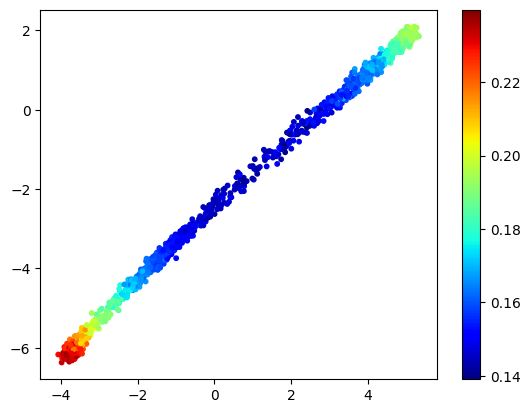

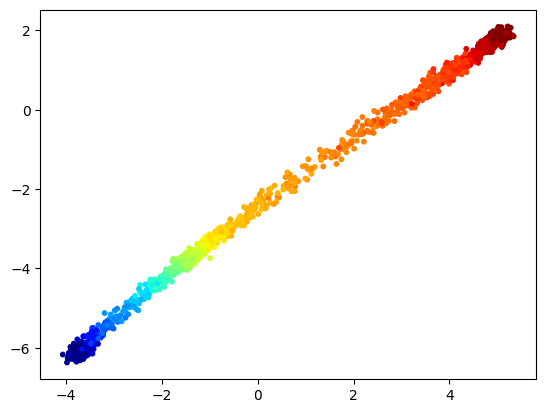

In [130]:
# 在mu0，mu1坐标系下投影Fisher矩阵模
plt.scatter(X_mu[:,0],X_mu[:,1],s=10,c=np.sum(1/X_sigma**2,axis=1),cmap=plt.cm.jet)
plt.colorbar()
plt.show()

# 在mu0，mu1坐标系下投影伪时间坐标
plt.scatter(X_mu[:,0],X_mu[:,1],s=10,c=X_label,cmap=plt.cm.jet)
plt.show()

In [131]:
def Fisher_dist(X1, X2): 
    # 这个定义和后面的Fisher_dist不是统一的，只是为了作为GE空间中KNN的一个度量
    dim=len(X1)//2

    mu1 = X1[:dim]
    sigma1 = X1[dim:]
    mu2 = X2[:dim]
    sigma2 = X2[dim:]
    
    dF2=0
    for i in range(dim):
        a=np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]+sigma2[i])**2)+\
          np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]-sigma2[i])**2)
        b=np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]+sigma2[i])**2)-\
          np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]-sigma2[i])**2)
        
        dF2+=2*(np.log(a/b))**2
    dF=np.sqrt(dF2)
    return dF

# 计算两个Gaussian之间的Wasserstein度量
def wasserstein_distance(X1, X2):
    dim=len(X1)//2

    mu1 = X1[:dim]
    sigma1 = X1[dim:]
    mu2 = X2[:dim]
    sigma2 = X2[dim:]

    dmu=mu1-mu2
    W_dist2=0
    for i in range(dim):
        W_dist2+=dmu[i]**2+sigma1[i]**2+sigma2[i]**2-2*np.sqrt(sigma2[i]*sigma1[i]**2*sigma2[i])
    W_dist=np.sqrt(W_dist2)
    return W_dist

def KL_dist(X1, X2):
    dim=len(X1)//2

    mu1 = X1[:dim]
    sigma1 = X1[dim:]
    mu2 = X2[:dim]
    sigma2 = X2[dim:]

    dmu=mu1-mu2
    KL_dist=0
    for i in range(dim):
        #the after KL_12+KL_21 the log(det(sigma1)/det(sigma2))+log(det(sigma2)/det(sigma1))=0
        # so do not calculate this term
        KL_12=1/2*(-1+sigma1[i]**2/sigma2[i]**2+dmu[i]**2/sigma2[i]**2)
        KL_21=1/2*(-1+sigma2[i]**2/sigma1[i]**2+dmu[i]**2/sigma1[i]**2)
        KL_sym=KL_12+KL_21
        KL_dist+=KL_sym
    return KL_dist

In [132]:
import anndata as ad
ge = ad.AnnData(latent_z)
scv.pp.neighbors(ge, n_neighbors=10, metric=Fisher_dist) # 计算了每个点的KNN

computing neighbors
    finished (0:01:29) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


In [133]:
k_nei = 10

row = np.array([np.ones((k_nei,))*i for i in range(ge.shape[0])]).flatten()
# row=[0,……0，1，……1，2，……adata.shape[0]]，k个0，k个1，……，k个adata.shape[0]

col=ge.uns['neighbors']['indices'].flatten()

adj_val=np.ones(col.shape)

A=csr_matrix((adj_val, (row, col)), shape=(ge.shape[0], ge.shape[0]))
# A_mat 就是把adata.obsp['connectivities']换成了0-1表示邻接关系的无权图，遗忘了边权

In [134]:
# 计算每个点处的Fisher度量阵
Fisher_g=np.zeros((X.shape[0],L*2,L*2))
for i in range(X.shape[0]):
    for j in range(L):
        Fisher_g[i,2*j,2*j]=1/(X_sigma[i,0]**2)
        Fisher_g[i,2*j+1,2*j+1]=2/(X_sigma[i,0]**2)

In [135]:
# for j in range(L*2):

#     plt.scatter(X_mu[:,0],X_mu[:,1],s=10,c=Fisher_g[:,j,j],cmap=plt.cm.jet)
#     plt.colorbar()
#     plt.show()

In [136]:
# 计算两个Gaussian之间的Fisher information
def Fisher_dist(mu1,sigma1,mu2,sigma2):
    dim=len(mu1)
    dF2=0
    for i in range(dim):
        a=np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]+sigma2[i])**2)+\
          np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]-sigma2[i])**2)
        b=np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]+sigma2[i])**2)-\
          np.sqrt(((mu1[i]-mu2[i])/np.sqrt(2))**2+(sigma1[i]-sigma2[i])**2)
        
        dF2+=2*(np.log(a/b))**2
    dF=np.sqrt(dF2)
    return dF

In [137]:
# 计算两个Gaussian之间的KL-divergence
def KL_dist(mu1,sigma1,mu2,sigma2):
    dim=len(mu1)
    dmu=mu1-mu2
    KL_dist=0
    for i in range(dim):
        #the after KL_12+KL_21 the log(det(sigma1)/det(sigma2))+log(det(sigma2)/det(sigma1))=0
        # so do not calculate this term
        KL_12=1/2*(-1+sigma1[i]**2/sigma2[i]**2+dmu[i]**2/sigma2[i]**2)
        KL_21=1/2*(-1+sigma2[i]**2/sigma1[i]**2+dmu[i]**2/sigma1[i]**2)
        KL_sym=KL_12+KL_21
        KL_dist+=KL_sym
    return KL_dist

In [138]:
X.shape

(1731, 470)

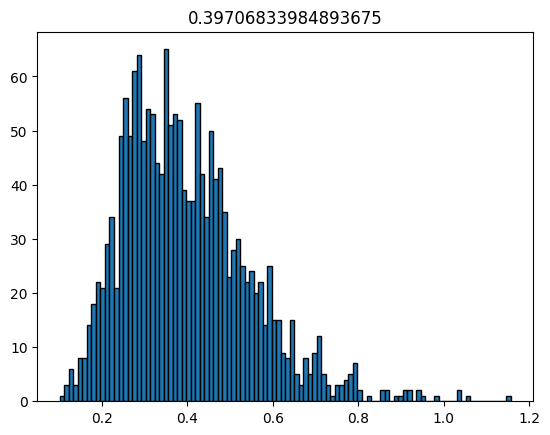

In [139]:
#-------------calcualte distance pair--------------
import math

dist_ratios=[]
for inds in np.split(A.indices, A.indptr)[1:-1]: # 遍历稀疏矩阵A所有非零元的坐标，从1开始表示邻居不算自己

    dist_r=[]
    self_ind=inds[0] # 坐标第一位置就是自己
    for nei_k in range(1,len(inds)):
        
        dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:]) # 这是计算了两个点在原始678维空间里的欧式度量
        dFi=Fisher_dist(X_mu[self_ind,:],X_sigma[self_ind,:],\
                        X_mu[inds[nei_k],:],X_sigma[inds[nei_k],:]) # 这是计算了两个点在GE空间中的Fisher Information度量

        gau_dEu=np.linalg.norm(X_mu[self_ind,:]-X_mu[inds[nei_k],:]) # 这是计算了两个点在GE空间中的欧式度量
        
        dKL=KL_dist(X_mu[self_ind,:],X_sigma[self_ind,:],\
                        X_mu[inds[nei_k],:],X_sigma[inds[nei_k],:]) # 这是计算了两个点在GE空间中的KL-divergence
        
        dist_r.append(dEu/dFi)  # 原空间欧式度量与GE空间Fisher度量之比
        
        
#     print(np.std(dist_r)/np.mean(dist_r))
    
    dist_ratios.append(np.std(dist_r)/np.mean(dist_r)) # 这是度量比的离散指数，描述度量比的离散程度

plt.hist(np.array(dist_ratios),bins=100,edgecolor='black')
for idx in range(len(dist_ratios)):
    if math.isnan(dist_ratios[idx]):
        dist_ratios[idx] = dist_ratios[-1]

plt.title(f'{np.mean(dist_ratios)}')
plt.savefig(f"EG_bin metric ratio radius layers common")
plt.show()

In [140]:
# 计算两个Gaussian之间的Wasserstein度量
def wasserstein_distance(mu1,sigma1,mu2,sigma2):
    dim=len(mu1)
    dmu=mu1-mu2
    W_dist2=0
    for i in range(dim):
        W_dist2+=dmu[i]**2+sigma1[i]**2+sigma2[i]**2-2*np.sqrt(sigma2[i]*sigma1[i]**2*sigma2[i])
    W_dist=np.sqrt(W_dist2)
    return W_dist

In [141]:
cRc_arr=[]
for inds in np.split(A.indices, A.indptr)[1:-1]:

    self_ind=inds[0]
    cRc=0
    for nei_k in range(1,len(inds)):
        
        dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:])
        dFi=Fisher_dist(X_mu[self_ind,:],X_sigma[self_ind,:],\
                        X_mu[inds[nei_k],:],X_sigma[inds[nei_k],:])
        dWa=wasserstein_distance(X_mu[self_ind,:],X_sigma[self_ind,:],\
                        X_mu[inds[nei_k],:],X_sigma[inds[nei_k],:])
        
        #cRc+=(1-dWa/dEu)
        cRc+=(1-dFi/dEu) # 尝试用Fisher度量定义CRC
    
    cRc_arr.append(cRc/len(inds)) # 计算了没个点处的标量曲率
#     cRc_arr.append(cRc)

In [142]:
# scv.pl.scatter(adata=adata0, basis='pca',c='ClusterName')

In [143]:
t = np.percentile(cRc_arr, 1) # 剔除后1%数据
idx = np.argwhere(cRc_arr > t).squeeze()

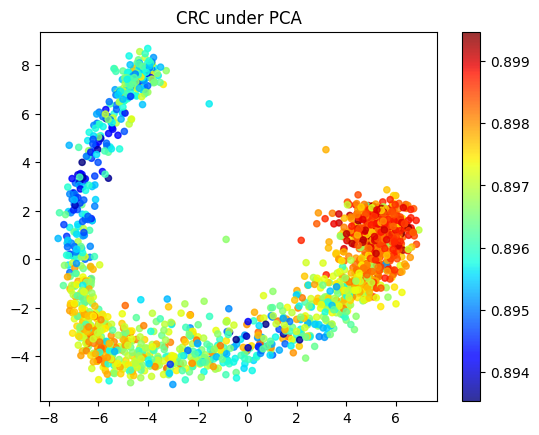

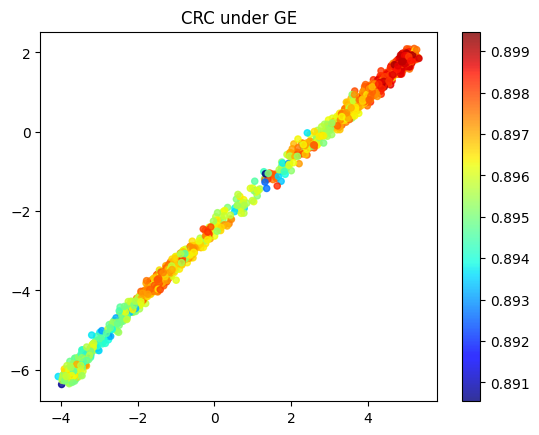

In [144]:
plt.scatter(adata0.obsm['X_pca'][idx,0],adata0.obsm['X_pca'][idx,1], c=np.array(cRc_arr)[idx], s=20, alpha=0.8,cmap=plt.cm.jet)
plt.colorbar()
plt.title("CRC under PCA")
plt.savefig('result_radius/DG_bin/10-max common radius layers ge KNN Fisher')
plt.show()

plt.scatter(X_mu[:,0],X_mu[:,1], c=cRc_arr, s=20, alpha=0.8,cmap=plt.cm.jet)
plt.colorbar()
plt.title("CRC under GE")
plt.show()

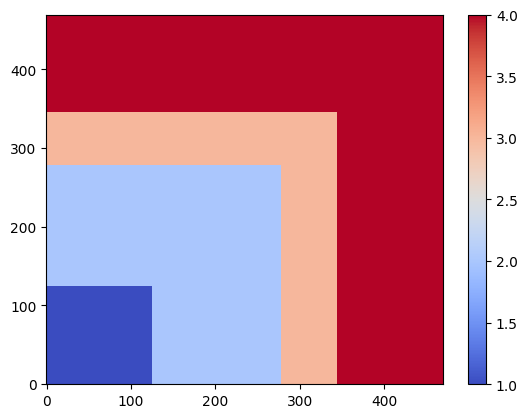

In [145]:
# 计算Eigen Gene
td=0.99
T=fcluster(Z, t=td, criterion='distance')

T_re=T[dg['leaves']]

X_corr_label=X_corr_re.copy()
for i in range(X_corr_re.shape[0]):
    X_corr_label[:,i]=T_re[i]
    X_corr_label[i,:]=T_re[i]

plt.imshow(X_corr_label, aspect='auto', cmap=plt.cm.coolwarm, interpolation='nearest',origin='lower')
plt.colorbar()
plt.show()



In [146]:
# eigen gene is the value of first principal component of each community
def eigen_gene(X_re,T_re):#return the weights of each gene in correponding eigen gene
    eigen_X_w=[]
    for i in np.unique(T_re):
        pca=PCA(n_components=0.98).fit(X_re[:,T_re==i])
#         print(pca.explained_variance_ratio_)
        pc1=pca.transform(X_re[:,T_re==i])[:,0]
        eigen_X_w.append(pca.components_[0,:])
#         eigen_gene_size.append(np.where(T_re==i)[0].shape[0])
    return eigen_X_w

In [147]:
# eigen_X_w用各个基因的权重 表示了eigen gene
# eigen_dim是eigen gene空间的维度，这里是3维，三个eigen gene分别有 274+244+160 三组基因加权表示
eigen_X_w=eigen_gene(X_re,T_re)
eigen_dim=len(np.unique(T_re))
# print(len(eigen_X_w[2]))


### Eigen Gene坐标下表示细胞

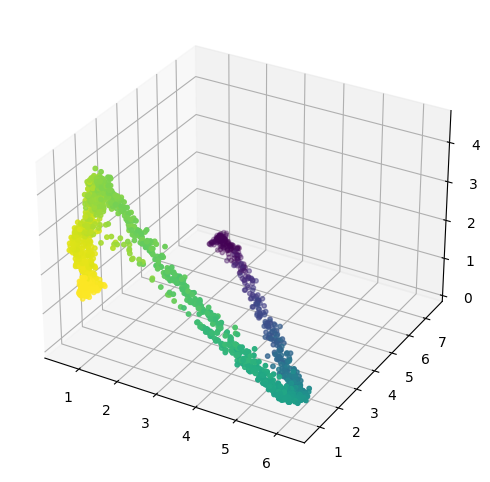

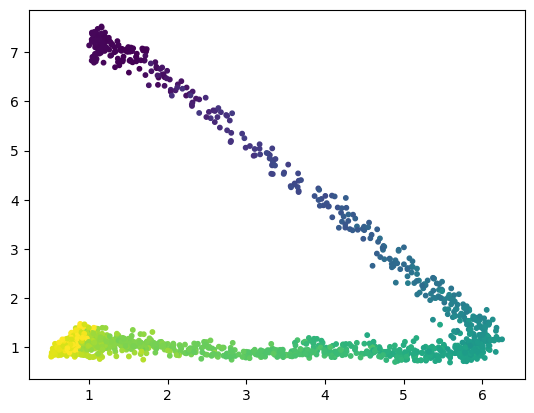

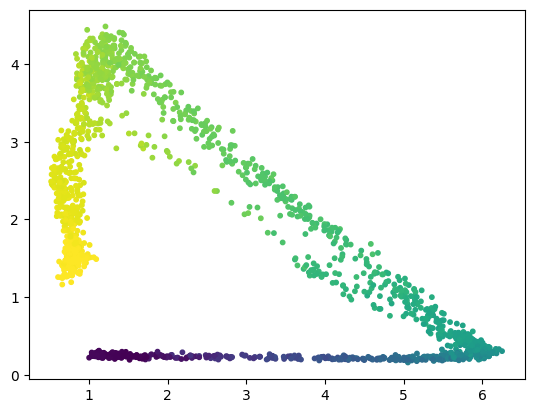

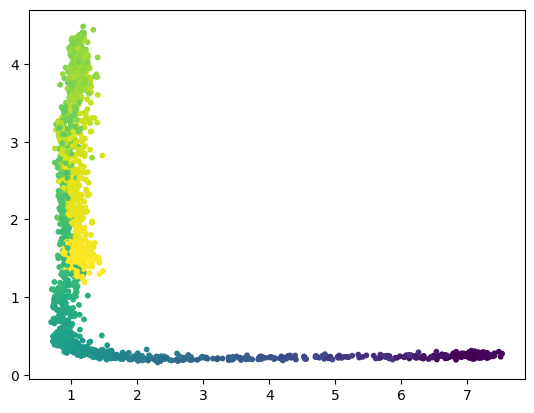

In [148]:
#---------eigen gene of each single cell----------------
cell_eigen_X=np.zeros((X_re.shape[0],eigen_dim))
for j in range(X_re.shape[0]):
    for k in range(len(eigen_X_w)):
        cell_eigen_X[j,k]=np.dot(eigen_X_w[k],X_re[j,T_re==k+1])

#plot eigen gene 
fig= plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cell_eigen_X[:,0],cell_eigen_X[:,1],cell_eigen_X[:,2],s=10,c=adata0.obs['velocity_pseudotime'])
plt.show()

plt.scatter(cell_eigen_X[:,0],cell_eigen_X[:,1],s=10,c=adata0.obs['velocity_pseudotime'])
plt.show()

plt.scatter(cell_eigen_X[:,0],cell_eigen_X[:,2],s=10,c=adata0.obs['velocity_pseudotime'])
plt.show()

plt.scatter(cell_eigen_X[:,1],cell_eigen_X[:,2],s=10,c=adata0.obs['velocity_pseudotime'])
plt.show()

In [149]:
# SparseVFC是RKHS中的一种逼近方法

vec_F=SparseVFC(cell_eigen_X,latent_z,Grid=cell_eigen_X)
#partial derivtive of Mu of each Gmm component with repect to each eigen gene
pMu_pEg=Jacobian_rkhs_gaussian(cell_eigen_X, vec_F)
pMu_pEg=np.transpose(np.array(pMu_pEg),[2,0,1])

In [150]:
pMu_pEg.shape

(1731, 6, 4)

In [151]:
# eigen gene坐标下的 Fisher度量
eigen_gij=np.zeros((X.shape[0],eigen_dim,eigen_dim))


for l in range(X.shape[0]):
#     loc_sample=[]
#     for s in range(n_sample):
#         loca_sample.append(multivariate_normal.rvs(mean=X_learned[l,:],cov=Y_learned[l,:]))


    for p in range(eigen_dim):
        for q in range(eigen_dim):
            for gi in range(L):
                eigen_gij[l,p,q]+=(1/latent_z[l,L+gi]**2)*pMu_pEg[l,gi,p]*pMu_pEg[l,gi,q]+\
                                  (2/latent_z[l,L+gi]**2)*pMu_pEg[l,gi+L,p]*pMu_pEg[l,gi+L,q]
 

In [152]:
eigen_gij.shape

(1731, 4, 4)

In [153]:
velo = np.array(adata0.layers['velocity'])
velo_re= velo[:,dg['leaves']]
# 按照聚类重排得RNAvelo
velo_re.shape

(1731, 470)

In [154]:
# eigen gene velocity
velo_eigen=np.zeros([X.shape[0], eigen_dim])
for i in range(X.shape[0]):
    for k in range(len(eigen_X_w)):
        velo_eigen[i,k]=np.dot(eigen_X_w[k],velo_re[i,T_re==k+1])
velo_eigen.shape

(1731, 4)

In [155]:
z_velo=[]

# zv2是GE velo的模长平方
zv2 = np.array([velo_eigen[l]@eigen_gij[l]@velo_eigen[l] for l in range(eigen_gij.shape[0])])

# zv1是GE velo的模长
zv1 = np.sqrt(zv2)
    

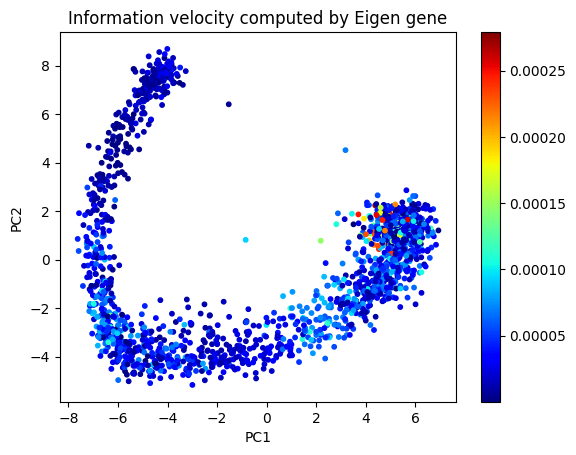

In [156]:
plt.scatter(adata0.obsm['X_pca'][:,0],adata0.obsm['X_pca'][:,1],s=10,c=zv1,cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("Information velocity computed by Eigen gene")
plt.show()


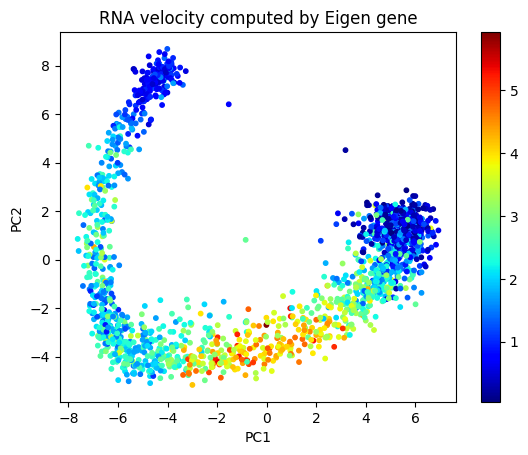

In [157]:

eigen_v_norm = np.array([np.dot(velo_eigen[l],velo_eigen[l]) for l in range(eigen_gij.shape[0])])
plt.scatter(adata0.obsm['X_pca'][:,0],adata0.obsm['X_pca'][:,1],s=10,c=eigen_v_norm,cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("RNA velocity computed by Eigen gene")
plt.show()
# 两种结果是consistent的

In [158]:
#---------------fisher info on pca


In [159]:

pca_dim=15
X_pca=adata.obsm['X_pca'][:,:pca_dim]
velo_pca=adata.obsm['velocity_pca'][:,:pca_dim]
vec_F=SparseVFC(X_pca,latent_z,Grid=X_pca)
#partial derivtive of Mu of each Gmm component with repect to each eigen gene
pMu_pEg=Jacobian_rkhs_gaussian(X_pca, vec_F)
pMu_pEg=np.transpose(np.array(pMu_pEg),[2,0,1])

In [160]:
pMu_pEg.shape

(1731, 6, 15)

In [161]:
pca_dim=X_pca.shape[1]
pca_gij=np.zeros((X.shape[0],pca_dim,pca_dim))


for l in range(X.shape[0]):
#     loc_sample=[]
#     for s in range(n_sample):
#         loca_sample.append(multivariate_normal.rvs(mean=X_learned[l,:],cov=Y_learned[l,:]))


    for p in range(pca_dim):
        for q in range(pca_dim):
            for gi in range(L):
                pca_gij[l,p,q]+=(1/latent_z[l,L+gi]**2)*pMu_pEg[l,gi,p]*pMu_pEg[l,gi,q]+\
                                  (2/latent_z[l,L+gi]**2)*pMu_pEg[l,gi+L,p]*pMu_pEg[l,gi+L,q]
            
            
#             pca_gij[l,p,q]=(1/latent_z[l,1]**2)*pMu_pEg[l,0,p]*pMu_pEg[l,0,q]+\
#                             (1/latent_z[l,3]**2)*pMu_pEg[l,2,p]*pMu_pEg[l,2,q]+\
#                             (2/latent_z[l,1]**2)*pMu_pEg[l,1,p]*pMu_pEg[l,1,q]+\
#                             (2/latent_z[l,3]**2)*pMu_pEg[l,3,p]*pMu_pEg[l,3,q]

In [162]:
z_velo=[]
zv2 = np.array([velo_pca[l]@pca_gij[l]@velo_pca[l] for l in range(pca_gij.shape[0])])
zv1 = np.sqrt(zv2)

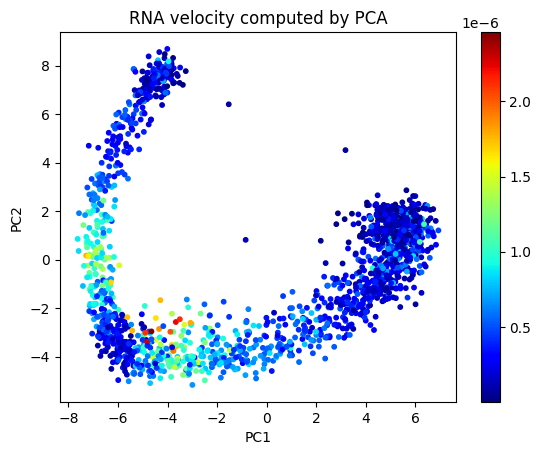

In [163]:
plt.scatter(adata0.obsm['X_pca'][:,0],adata0.obsm['X_pca'][:,1],s=10,c=zv1,cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("RNA velocity computed by PCA")
plt.show()


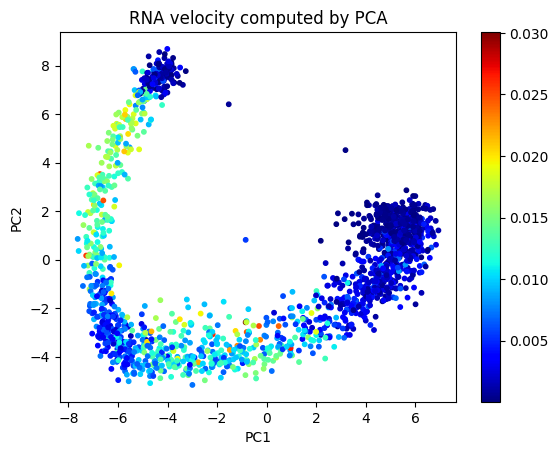

In [164]:
pca_v_norm = np.array([np.dot(velo_pca[l],velo_pca[l]) for l in range(pca_gij.shape[0])])
plt.scatter(adata0.obsm['X_pca'][:,0],adata0.obsm['X_pca'][:,1],s=10,c=pca_v_norm,cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("RNA velocity computed by PCA")
plt.show()


In [165]:
np.argsort(np.array([1,3,2,5,4]))

array([0, 2, 1, 4, 3], dtype=int64)

In [166]:
5.4//2

2.0